##Clone SrdyPy from git

In [ ]:
!rm -rf SrdPy
!git clone https://github.com/RumblingTurtle/SrdPy.git

Cloning into 'SrdPy'...
remote: Enumerating objects: 373, done.
remote: Counting objects: 100% (373/373), done.
remote: Compressing objects: 100% (271/271), done.
remote: Total 373 (delta 172), reused 297 (delta 96), pack-reused 0
Receiving objects: 100% (373/373), 4.04 MiB | 3.32 MiB/s, done.
Resolving deltas: 100% (172/172), done.


##Clone colab compatible meshcat repo and install casadi

In [ ]:
!pip install git+https://github.com/rdeits/meshcat-python.git@master
!pip install casadi
!pip install control
!pip install slycot
!pip install urdf-parser-py
!pip install pyngrok

  Cloning https://github.com/rdeits/meshcat-python.git (to revision master) to /tmp/pip-req-build-va_rbb_e
  Running command git clone -q https://github.com/rdeits/meshcat-python.git /tmp/pip-req-build-va_rbb_e
  Running command git submodule update --init --recursive -q
  Created wheel for meshcat: filename=meshcat-0.0.19-cp36-none-any.whl size=627628 sha256=11445a2b403a8a0ad1d3affa6a1621dcd827ae888eb43574e1164965afe9e007
  Stored in directory: /tmp/pip-ephem-wheel-cache-h0zl2b98/wheels/c2/57/90/f09f46ded98f6ea0f4dd05029529fe8d24d936a520786a60e0
Successfully built meshcat


In [1]:
from SrdPy.LinksAndJoints import *
from SrdPy.Handlers import *
from SrdPy.InverseKinematics import *
from SrdPy.SymbolicUtils import *
from SrdPy.Loggers import *
from SrdPy.DynamicSolvers import *
from SrdPy.Controllers import *
from SrdPy import SymbolicEngine
from SrdPy.Visuals import Visualizer
from casadi import *
from copy import deepcopy
from SrdPy import Chain
import numpy as np
import os
import time

ModuleNotFoundError: No module named 'SrdPy'

##Import a robot from URDF file

In [ ]:
from SrdPy.URDFUtils import getLinkArrayFromURDF

iiwaLinks = getLinkArrayFromURDF("./SrdPy/iiwa/iiwa14.urdf",True)
iiwaChain = Chain(iiwaLinks)
iiwaChain.update(np.array([1]*7))
vis = Visualizer()
vis.show(iiwaChain,True)

Unknown tag: material
Unknown tag: self_collision_checking
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface


You can open the visualizer by visiting the following URL:
http://0327d338343f.ngrok.io/static/


##Or define it yourself

In [ ]:
groundLink = GroundLink()

link1 = Link(name="Link1", order=1, inertia=np.diag([1/12*10*0.5, 1/12*10*0.5, 0.1*1/12*10*0.5]), mass=1,
                relativeBase=[0, 0, 0], relativeFollower=[[0, 0, 0.5]], relativeCoM=[0, 0, 0.25])

link2 = Link(name="Link2", order=1, inertia=np.diag([1/12*10*0.5, 1/12*10*0.5, 0.1*1/12*10*0.5]), mass=1,
                relativeBase=[0, 0, 0], relativeFollower=[[0, 0, 0.5]], relativeCoM=[0, 0, 0.25])

link3 = Link(name="Link3", order=1, inertia=np.diag([1/12*10*0.5, 1/12*10*0.5, 0.1*1/12*10*0.5]), mass=1,
                relativeBase=[0, 0, 0], relativeFollower=[[0, 0, 0.5]], relativeCoM=[0, 0, 0.25])


##Define joints connecting the links

In [ ]:
genCoordIndex = 0

newCoordIndices = [0]
jointGto1 = JointPivotX(name="GroundToFirst", childLink=link1, parentLink=groundLink, parentFollowerNumber=0,
                          usedGeneralizedCoordinates=newCoordIndices, usedControlInputs=newCoordIndices,
                          defaultJointOrientation=np.eye(3))

newCoordIndices = [1]
joint1to2 = JointPivotX(name="1To2", childLink=link2, parentLink=link1, parentFollowerNumber=0,
                            usedGeneralizedCoordinates=newCoordIndices, usedControlInputs=newCoordIndices,
                            defaultJointOrientation=np.eye(3))

newCoordIndices = [2]
joint2to3 = JointPivotX(name="2To3", childLink=link3, parentLink=link2, parentFollowerNumber=0,
                            usedGeneralizedCoordinates=newCoordIndices, usedControlInputs=newCoordIndices,
                            defaultJointOrientation=np.eye(3))


##Create a chain and update joint positions

In [ ]:
initialPosition = np.array([np.pi/4, -2*np.pi/3, 1*np.pi/5])
linkArray = [groundLink, link1, link2, link3]

chain = Chain(linkArray)
blank_chain = deepcopy(chain)
blank_chain.update(initialPosition)

##Display robot

In [ ]:
vis = Visualizer()
vis.show(blank_chain)

You can open the visualizer by visiting the following URL:
http://17d3e5b6229a.ngrok.io/static/


##Define dynamics constraints

In [ ]:
engine = SymbolicEngine(chain.linkArray)
deriveJacobiansForlinkArray(engine)
H = deriveJSIM(engine)

iN, dH = deriveGeneralizedInertialForces_dH(engine,H)
g = deriveGeneralizedGravitationalForces(engine)
d = deriveGeneralizedDissipativeForcesUniform(engine, 1)

#NaiveControlMap
T = deriveControlMap(engine)

description_gen_coord_model = generateDynamicsGeneralizedCoordinatesModel(engine,
                                            H=H,
                                            c=(iN+g+d),
                                            T=T,
                                            functionName_H="g_dynamics_H",
                                            functionName_c="g_dynamics_c",
                                            functionName_T="g_dynamics_T",
                                            casadi_cCodeFilename="g_dynamics_generalized_coordinates",
                                            path="./Dynamics")

handlerGeneralizedCoordinatesModel = GeneralizedCoordinatesModelHandler(description_gen_coord_model)


description_linearization = generateDynamicsLinearization(engine,
                                            H=H,
                                            c=(iN + g + d),
                                            T=T,
                                            functionName_A="g_linearization_A",
                                            functionName_B="g_linearization_B",
                                            functionName_c="g_linearization_c",
                                            casadi_cCodeFilename="g_dynamics_linearization",
                                            path="./Linearization")
handlerLinearizedModel = LinearizedModelHandler(description_linearization)

constraint = engine.linkArray[3].absoluteFollower[0][2]

description_constraints = generateSecondDerivativeJacobians(engine,
                                                            task=constraint,
                                                            functionName_Task="g_Constraint",
                                                            functionName_TaskJacobian="g_Constraint_Jacobian",
                                                            functionName_TaskJacobianDerivative="g_Constraint_Jacobian_derivative",
                                                            casadi_cCodeFilename="g_Constraints",
                                                            path="./Constraints")
handlerConstraints = ConstraintsModelHandler(description_constraints,engine.dof)


task = vertcat(vertcat(engine.q[0], engine.q[1]), constraint)

description_IK = generateSecondDerivativeJacobians(engine,
                                                            task=task,
                                                            functionName_Task="g_InverseKinematics_Task",
                                                            functionName_TaskJacobian="g_InverseKinematics_TaskJacobian",
                                                            functionName_TaskJacobianDerivative="g_InverseKinematics_TaskJacobian_derivative",
                                                            casadi_cCodeFilename="g_InverseKinematics",
                                                            path="./InverseKinematics")


(3, 1)
Starting writing function for the g_dynamics_H
Starting writing function for the g_dynamics_c
Starting writing function for the g_dynamics_T
Running gcc -fPIC -shared g_dynamics_generalized_coordinates.c -o g_dynamics_generalized_coordinates.so
Generated C code!
Starting writing function for the g_linearization_A
Starting writing function for the g_linearization_B
Starting writing function for the g_linearization_c
Running gcc -fPIC -shared g_dynamics_linearization.c -o g_dynamics_linearization.so
Generated C code!
Starting writing function for the g_Constraint
Starting writing function for the g_Constraint task jacobian
Starting writing function for the derivative of g_Constraint
Running gcc -fPIC -shared g_Constraints.c -o g_Constraints.so
Generated C code!
Starting writing function for the g_InverseKinematics_Task
Starting writing function for the g_InverseKinematics_Task task jacobian
Starting writing function for the derivative of g_InverseKinematics_Task
Running gcc -fPIC 

##IK task design

In [ ]:
ikModelHandler = IKModelHandler(description_IK, engine.dof, task.shape[0])
IC_task = ikModelHandler.getTask(initialPosition)

zeroOrderDerivativeNodes = [[IC_task[0], IC_task[0] - 0.15],
                            [IC_task[1], IC_task[1] + 0.15 ],
                            [IC_task[2], IC_task[2]]]

firstOrderDerivativeNodes = [[0, 0],
                                [0, 0],
                                [0, 0]]

secondOrderDerivativeNodes = [[0, 0],
                                [0, 0],
                                [0, 0]]

timeOfOneStage = 2
timeEnd = (len(zeroOrderDerivativeNodes[1]) - 1) * timeOfOneStage + 1
nodeTimes = np.arange(start=0, stop=timeEnd, step=timeOfOneStage)

handlerIK_taskSplines = IKtaskSplinesHandler(nodeTimes,
                                                zeroOrderDerivativeNodes, firstOrderDerivativeNodes,
                                                secondOrderDerivativeNodes)

timeTable = np.arange(handlerIK_taskSplines.timeStart, handlerIK_taskSplines.timeExpiration + 0.01, 0.01)
IKTable = generateIKTable(ikModelHandler, handlerIK_taskSplines, initialPosition, timeTable)

plotIKTable(ikModelHandler, timeTable, IKTable)

ikSolutionHandler = IKSolutionHandler(ikModelHandler, handlerIK_taskSplines, timeTable, IKTable, "linear")

Calculating  0.0%
Calculating  0.0%
Calculating  1.0%
Calculating  2.0%
Calculating  3.0%
Calculating  4.0%
Calculating  5.0%
Calculating  6.0%
Calculating  7.0%
Calculating  8.0%
Calculating  9.0%
Calculating  10.0%
Calculating  11.0%
Calculating  12.0%
Calculating  13.0%
Calculating  14.0%
Calculating  15.0%
Calculating  16.0%
Calculating  17.0%
Calculating  18.0%
Calculating  19.0%
Calculating  20.0%
Calculating  21.0%
Calculating  22.0%
Calculating  23.0%
Calculating  24.0%
Calculating  25.0%
Calculating  26.0%
Calculating  27.0%
Calculating  28.0%
Calculating  29.0%
Calculating  30.0%
Calculating  31.0%
Calculating  32.0%
Calculating  33.0%
Calculating  34.0%
Calculating  35.0%
Calculating  36.0%
Calculating  37.0%
Calculating  38.0%
Calculating  39.0%
Calculating  40.0%
Calculating  41.0%
Calculating  42.0%
Calculating  43.0%
Calculating  44.0%
Calculating  45.0%
Calculating  46.0%
Calculating  47.0%
Calculating  48.0%
Calculating  49.0%
Calculating  50.0%
Calculating  51.0%
Calc

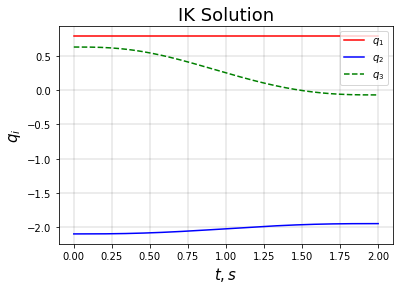

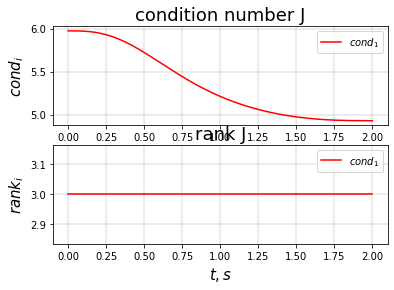

In [ ]:
plotIKTable(ikModelHandler, timeTable, IKTable)

##Simulation

In [1]:
stateHandler = StateHandler(initialPosition, np.zeros(len(initialPosition)))
gcModelEvaluator = GCModelEvaluatorHandler(handlerGeneralizedCoordinatesModel, stateHandler)
linearModelEvaluator = LinearModelEvaluatorHandler(handlerGeneralizedCoordinatesModel, handlerLinearizedModel,
                                                        stateHandler, [], False)

dt = 0.001
tf = ikSolutionHandler.timeExpiration

simulationHandler = SimulationHandler(np.arange(0, tf, dt))

desiredStateHandler = DesiredStateHandler(ikSolutionHandler, simulationHandler)

stateSpaceHandler = StateConverterGenCoord2StateSpaceHandler(stateHandler)

desiredStateSpaceHandler = StateConverterGenCoord2StateSpaceHandler(desiredStateHandler)

#    inverseDynamicsHandler = getIDVanillaDesiredTrajectoryHandler(desiredStateHandler, gcModelEvaluator,
#                                                                  simulationHandler)
inverseDynamicsHandler = InverseDynamicsConstrained_QR(
                        desiredStateHandler,
                        handlerConstraints,
                        gcModelEvaluator,
                        simulationHandler)

computedTorqueController = ComputedTorqueController(stateHandler, desiredStateHandler,
                                                        gcModelEvaluator, simulationHandler, inverseDynamicsHandler,
                                                        500 * np.eye(desiredStateHandler.dofRobot),
                                                        100 * np.eye(desiredStateHandler.dofRobot))


                        
#    LQRHandler = getLQRControllerHandler(stateSpaceHandler, desiredStateSpaceHandler, linearModelEvaluator,
#                                         simulationHandler,
#                                         inverseDynamicsHandler, 10 * np.eye(linearModelEvaluator.dofRobotStateSpace),
#                                         np.eye(linearModelEvaluator.dofControl))
LQRHandler = ConstrainedLQRController(stateHandler,stateSpaceHandler, desiredStateSpaceHandler, linearModelEvaluator,handlerConstraints,
                                        simulationHandler,
                                        inverseDynamicsHandler, 10 * np.eye(linearModelEvaluator.dofRobotStateSpace),
                                        np.eye(linearModelEvaluator.dofControl))

mainController = LQRHandler

linearModelEvaluator.controllerHandler = inverseDynamicsHandler

taylorSolverHandler = ConstrainedTaylorSolverHandler(stateHandler, mainController, gcModelEvaluator, simulationHandler,handlerConstraints)

stateHandlerLogger = StateLoggerHandler(stateHandler, simulationHandler)

tickLogger = ProgressDisplayHandler(simulationHandler)

preprocessingHandlers = [desiredStateHandler, stateSpaceHandler, desiredStateSpaceHandler, gcModelEvaluator]
controllerHandlers = [inverseDynamicsHandler, linearModelEvaluator, LQRHandler]
solverHandlers = [taylorSolverHandler]
loggerHandlers = [stateHandlerLogger, tickLogger]

simulationHandler.preprocessingHandlersArray = preprocessingHandlers
simulationHandler.controllerArray = controllerHandlers
simulationHandler.solverArray = solverHandlers
simulationHandler.loggerArray = loggerHandlers

simulationHandler.simulate()

NameError: name 'getStateHandler' is not defined

In [ ]:
vis = Visualizer()
vis.animate(blank_chain,stateHandlerLogger.q,framerate=0.1)

You can open the visualizer by visiting the following URL:
http://a477543a7d89.ngrok.io/static/


##Plot optimized variables

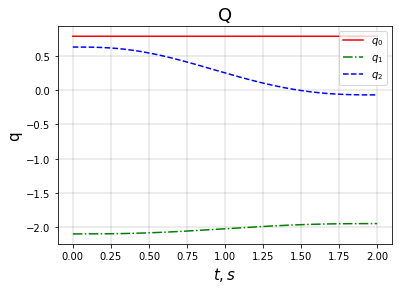

In [ ]:
from SrdPy import plotGeneric
plotGeneric(simulationHandler.timeLog[:-1],stateHandlerLogger.q,figureTitle="Q",ylabel="q")

In [ ]:
plotGeneric(simulationHandler.timeLog[:-1], stateHandlerLogger.v, figureTitle="V", ylabel="v")